# Install libraries

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-gpu==2.5.0 

     |████████████████████████████████| 454.4 MB 11 kB/s s eta 0:00:01     |█████████████████▊              | 251.9 MB 10.6 MB/s eta 0:00:20
     |████████████████████████████████| 14.9 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 12.5 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=9b589158160585abb57355a657db34eff0ba567e6a55d8afa48baca266eae858
  Stored in directory: /home/harsh/.cache/pip/wheels/b6/0d/90/0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Att

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


# Data loader

In [28]:
# Maximum length of comment
max_len = 128 
# Dimension of embedding vector
embedding_dim = 100 
# Max feature
max_feature = 10000

In [6]:
# Read data
import pandas as pd
from ast import literal_eval

data = pd.read_csv('/home/harsh/Downloads/tsd_train.csv')
dev = pd.read_csv('/home/harsh/Downloads/tsd_trial.csv')
test = pd.read_csv('/home/harsh/Downloads/tsd_test.csv')

text_data = data['text'].values
spans = data['spans'].apply(literal_eval)
lbl = [1 if len(s) > 0 else 0 for s in spans]

text_data_test = test['text'].values
spans_test = test['spans'].apply(literal_eval)
test_id = test.index
lbl_test = [1 if len(s) > 0 else 0 for s in spans_test]

text_data_dev = dev['text'].values
spans_dev = dev['spans'].apply(literal_eval)
dev_id = dev.index
lbl_dev = [1 if len(s) > 0 else 0 for s in spans_dev]

In [7]:
pip install -U spacy

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires absl-py>=1.0.0, but you have absl-py 0.15.0 which is incompatible.
tensorflow 2.10.0 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tensorflow 2.10.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.10.0 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.5.0 which is incompatible.
tensorflow-gpu 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Token level 

from nltk.tokenize import TweetTokenizer
import numpy as np
# import spacy

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    return tknzr2.tokenize(text_data)

def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1]-1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def span_retrived(text_data, spans):
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))
    
    return token_labels

def span_convert(text_data, spans):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))

    lst_seq = []
    for i in range(0, len(text_data)):
        # token = tknzr.tokenize(text_data[i])
        token = custom_tokenizer(text_data[i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                # if token[j] in tknzr.tokenize(t):
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)     

    return (token_labels, lst_seq)

In [10]:
from copy import deepcopy

# convert data
data['token'], data['seq'] = span_convert(text_data, spans)
dev['token'], dev['seq'] = span_convert(text_data_dev, spans_dev)
test['token'], test['seq'] = span_convert(text_data_test, spans_test)

train = deepcopy(data)
data = pd.concat([data, dev])

# Evaluation metric 

In [11]:
# Evaluation metric

import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # # read the predictions
    # pred_lines = pred.readlines()
    # # read the ground truth
    # gold_lines = gold.readlines()

    pred_lines = pred
    gold_lines = gold

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

# Data analysis 

In [12]:
# Number of training data
print(len(train))

7939


In [13]:
# Number of test data
print(len(test))

2000


In [14]:
test

,spans,text,token,seq
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",That's right. They are not normal. And I am st...,"[ABNORMAL, sexist rubbish]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt...",[stupid],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[],tens years ago i contacted the PDR and suggest...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[],The parallels between the ANC and the Sicilian...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[],Intel Community: ‘How can we work for a Presid...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1995,"[4, 5, 6, 7, 8, 70, 71, 72, 73, 74, 75, 76, 77...",hey loser change your name to something more a...,"[loser, ignorant, loser]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1996,"[23, 24, 25, 26, 27]",And you are a complete moron who obviously doe...,[moron],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1997,"[157, 158, 159, 160, 161, 162, 163, 164, 165, ...",Such vitriol from the left. Who would have th...,[hypocrites],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,[],It is now time for most of you to expand your ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [15]:
# Show example of training data
train.tail(20)

,spans,text,token,seq
7919,"[49, 50, 51, 52, 53, 54]","Ah, so sad. It certainly does seem to bother t...",[trolls],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7920,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","Yes, let's end the insanity! No more trans pe...",[No more trans people! No more boys kissing bo...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7921,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Such garbage logic by republicans which will b...,[Such garbage logic by republicans],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7922,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 96, 97, 9...",aa the usual left wing attack of stupidity is ...,"[stupidity, crying that wont stop]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
7923,"[37, 38, 39, 40, 41]",The G&M doesn't need to repeat EVERY idiot thi...,[idiot],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7924,"[177, 178, 179, 180, 181, 182, 183, 184, 185]","All this reality tv suspense, all this loud no...",[stupidity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7925,"[15, 16, 17, 18, 19, 20]",Can't get over idiots like yourself who probab...,[idiots],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7926,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 4...",I only use the word haole when stupidity and a...,"[stupidity, arrogance]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
7927,"[132, 133, 134, 135]",Pity Vegter doesn't apply the same rigour he n...,[dick],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7928,"[54, 55, 56, 57]","Anyone who voted for Hillary is blind, gullibl...",[fool],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [16]:
# counting word in spans for train 
len_span = train['token'].apply(len)

In [17]:
# counting word in spans for test 
len_span_test = test['token'].apply(len)

In [18]:
# Statistic spans by number of word in span for train 
len_span.value_counts(normalize=True, sort=True)

1     0.676534
2     0.200655
0     0.061091
3     0.043330
4     0.011588
5     0.003401
6     0.001512
7     0.001008
8     0.000504
25    0.000126
9     0.000126
11    0.000126
Name: token, dtype: float64

In [19]:
# Statistic spans by number of word in span for test 
len_span_test.value_counts(normalize=True, sort=True)

1    0.7035
0    0.1970
2    0.0860
3    0.0080
4    0.0040
6    0.0010
7    0.0005
Name: token, dtype: float64

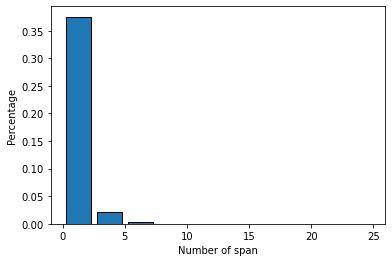

In [20]:
# Distribution histogram plot
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

fig, ax = plt.subplots()

ax.hist(len_span, density=True, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.ylabel('Percentage')
plt.xlabel('Number of span');

# Word embedding

In [21]:
# Read embedding
word_dict = []
embeddings_index = {}
f = open('/home/harsh/Downloads/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')


GloVe data loaded


In [22]:
words = word_dict
num_words = len(words)

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
idx2word = {i: w for w, i in word_to_index.items()}

In [29]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [30]:
 # mapping for token cases
case2Idx = {'1': 1, '0': 0}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

char2Idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char2Idx[c] = len(char2Idx)

# Data pre-processing 

In [31]:
from sklearn.model_selection import train_test_split

y = data['seq']
X = data['text']

y_test = test['seq']
X_test = test['text']

In [32]:
#train test
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.1)

In [37]:
pip install Keras==2.0.0

     |████████████████████████████████| 191 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 588.3 MB 9.3 kB/s  eta 0:00:01
     |████████████████████████████████| 578.1 MB 18 kB/s s eta 0:00:01
     |████████████████████████████████| 511.8 MB 15 kB/s  eta 0:00:012
     |████████████████████████████████| 511.8 MB 8.3 kB/s eta 0:00:019     |█████████████████████████████▋  | 473.8 MB 9.9 MB/s eta 0:00:04
     |████████████████████████████████| 511.7 MB 1.6 kB/s  eta 0:00:01
     |████████████████████████████████| 511.7 MB 18 kB/s s eta 0:00:01     |█████████████████████████████▍  | 470.6 MB 13.0 MB/s eta 0:00:04
     |████████████████████████████████| 498.1 MB 14 kB/s  eta 0:00:014     |███████████████████▎            | 299.3 MB 6.0 MB/s eta 0:00:33
     |████████████████████████████████| 462 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 498.5 MB 5.8 kB/s eta 0:00:011     |████████████▌ 

     |█████▉                          | 88.9 MB 11.3 MB/s eta 0:00:36                       | 35.5 MB 11.3 MB/s eta 0:00:41         | 86.2 MB 11.3 MB/s eta 0:00:36    |█████▋                          | 86.4 MB 11.3 MB/s eta 0:00:36    | 86.7 MB 11.3 MB/s eta 0:00:36     |████████████████████████████████| 489.7 MB 5.2 kB/s  eta 0:00:0110:101:0901:09470:47:00:47 0:00:47      | 171.5 MB 5.8 MB/s eta 0:00:56█████████████████▍          | 327.2 MB 5.5 MB/s eta 0:00:30�█████████████▍          | 327.3 MB 5.5 MB/s eta 0:00:30�████████▌     | 404.9 MB 7.9 MB/s eta 0:00:11 | 407.9 MB 9.0 MB/s eta 0:00:10 | 410.0 MB 9.0 MB/s eta 0:00:09�█▋ | 468.0 MB 10.8 MB/s eta 0:00:036 MB 8.7 MB/s eta 0:00:03
     |████████████████████████████████| 464.3 MB 404 bytes/s  0:00:012  | 82.9 MB 7.5 MB/s eta 0:00:51               | 136.6 MB 6.2 MB/s eta 0:00:53    |███████████████▏                | 220.2 MB 7.8 MB/s eta 0:00:32    |███████████████▌                | 225.5 MB 2.2 MB/s eta 0:01:47███████████████▌      

     |████                            | 56.5 MB 10.9 MB/s eta 0:00:38                       | 296 kB 8.2 MB/s eta 0:00:57             | 583 kB 8.2 MB/s eta 0:00:57 | 870 kB 8.2 MB/s eta 0:00:572 MB/s eta 0:00:57:00:572 MB/s eta 0:00:57��                               | 2.0 MB 8.2 MB/s eta 0:00:5700:57                    | 4.3 MB 8.2 MB/s eta 0:00:57      | 5.1 MB 8.2 MB/s eta 0:00:57                              | 6.1 MB 8.2 MB/s eta 0:00:56               | 8.9 MB 4.5 MB/s eta 0:01:42                              | 9.5 MB 4.5 MB/s eta 0:01:42 | 9.7 MB 4.5 MB/s eta 0:01:42 0:01:42:01:421:4141[K     |▉                               | 11.4 MB 4.5 MB/s eta 0:01:41[K     |█                               | 13.9 MB 4.5 MB/s eta 0:01:41     |█                               | 14.1 MB 4.5 MB/s eta 0:01:41   |█                               | 14.4 MB 4.5 MB/s eta 0:01:41B 4.5 MB/s eta 0:01:40�                              | 17.6 MB 11.6 MB/s eta 0:00:39390:39:00:39390:390:39 0:00:39ta 0:00:38 eta

     |████████████████████▎           | 294.2 MB 395 kB/s eta 0:07:11021 kB/s eta 0:13:44        | 192.6 MB 331 kB/s eta 0:13:40331 kB/s eta 0:13:37[K     |█████████████▌                  | 195.5 MB 331 kB/s eta 0:13:3231 kB/s eta 0:13:28        | 197.0 MB 331 kB/s eta 0:13:27�██▋                  | 197.2 MB 331 kB/s eta 0:13:26 kB/s eta 0:13:216.3 MB/s eta 0:00:43�█████████▉                  | 200.1 MB 6.3 MB/s eta 0:00:43.3 MB/s eta 0:00:43        | 200.7 MB 6.3 MB/s eta 0:00:43�██▉                  | 200.9 MB 6.3 MB/s eta 0:00:42█████████▉                  | 201.1 MB 6.3 MB/s eta 0:00:42[K     |█████████████▉                  | 201.3 MB 6.3 MB/s eta 0:00:423 MB/s eta 0:00:42       | 201.7 MB 6.3 MB/s eta 0:00:42███                  | 201.9 MB 6.3 MB/s eta 0:00:42��█████████                  | 202.1 MB 6.3 MB/s eta 0:00:42K     |██████████████                  | 202.3 MB 6.3 MB/s eta 0:00:426.3 MB/s eta 0:00:42         | 202.9 MB 6.3 MB/s eta 0:00:42��███                  | 203.1 MB 

     |██████████████████████�████▋    | 401.1 MB 318 kB/s eta 0:03:192��█▎           | 294.9 MB 395 kB/s eta 0:07:09�████████▍           | 296.3 MB 395 kB/s eta 0:07:06 297.3 MB 395 kB/s eta 0:07:03�████████▌           | 298.1 MB 395 kB/s eta 0:07:01ta 0:06:57��███████████▋           | 299.9 MB 395 kB/s eta 0:06:56��██████▊           | 301.3 MB 395 kB/s eta 0:06:53�████████▉           | 301.7 MB 395 kB/s eta 0:06:52ta 0:06:48��████████████           | 303.5 MB 395 kB/s eta 0:06:47395 kB/s eta 0:06:43�█████████           | 305.3 MB 395 kB/s eta 0:06:43███████████           | 306.2 MB 395 kB/s eta 0:06:41�█████████████▏          | 307.5 MB 873 kB/s eta 0:03:00��█████████▏          | 307.6 MB 873 kB/s eta 0:03:00��████████████████████▎          | 308.8 MB 873 kB/s eta 0:02:59█████████████████▎          | 309.0 MB 873 kB/s eta 0:02:583 kB/s eta 0:02:57��████████████████████▍          | 310.8 MB 873 kB/s eta 0:02:56�██▌          | 311.7 MB 873 kB/s eta 0:02:55██████▋          | 313.5 MB 873

     |███████████████████████████████▏| 452.3 MB 200 kB/s eta 0:01:00�████▊    | 401.5 MB 318 kB/s eta 0:03:18��█████████████████████████▊    | 401.6 MB 318 kB/s eta 0:03:17████▊    | 401.8 MB 318 kB/s eta 0:03:17��███▊    | 402.1 MB 318 kB/s eta 0:03:16��████████▊    | 402.9 MB 320 kB/s eta 0:03:12[K     |███████████████████████████▉    | 403.4 MB 320 kB/s eta 0:03:11████████▉    | 403.5 MB 320 kB/s eta 0:03:10    |███████████████████████████▉    | 404.3 MB 320 kB/s eta 0:03:08███████▉    | 404.5 MB 320 kB/s eta 0:03:07��███████    | 404.8 MB 320 kB/s eta 0:03:06 |████████████████████████████    | 405.3 MB 320 kB/s eta 0:03:05��█████████    | 406.1 MB 320 kB/s eta 0:03:02K     |████████████████████████████    | 406.9 MB 320 kB/s eta 0:03:00�████████    | 407.3 MB 320 kB/s eta 0:02:58     |████████████████████████████    | 407.5 MB 320 kB/s eta 0:02:58�████████    | 407.6 MB 320 kB/s eta 0:02:57�█████████████████████▏   | 408.4 MB 320 kB/s eta 0:02:55| 408.7 MB 320 kB/s eta 0:02:54��██

     |████████████████████████████████| 464.3 MB 19 kB/s  eta 0:00:010452.8 MB 200 kB/s eta 0:00:58███████▎| 453.1 MB 316 kB/s eta 0:00:36�█████████████████████████▎| 453.3 MB 316 kB/s eta 0:00:3553.4 MB 316 kB/s eta 0:00:35454.2 MB 316 kB/s eta 0:00:33��████████████████▎| 454.3 MB 316 kB/s eta 0:00:32███████▎| 454.5 MB 316 kB/s eta 0:00:310�███████▍| 455.3 MB 316 kB/s eta 0:00:29███████▍| 455.9 MB 316 kB/s eta 0:00:27�█████████████████████████▍| 456.0 MB 316 kB/s eta 0:00:2756.2 MB 316 kB/s eta 0:00:26�████████████████▌| 456.3 MB 316 kB/s eta 0:00:265��█████████████████████████▌| 456.8 MB 316 kB/s eta 0:00:24456.9 MB 316 kB/s eta 0:00:24███████▌| 457.3 MB 235 kB/s eta 0:00:3057.6 MB 235 kB/s eta 0:00:29�████████████████▌| 457.7 MB 235 kB/s eta 0:00:28458.3 MB 235 kB/s eta 0:00:26��████████████████▋| 458.5 MB 235 kB/s eta 0:00:25███████▋| 458.7 MB 235 kB/s eta 0:00:24�███████▋| 459.4 MB 235 kB/s eta 0:00:21��█████████████████████████▊| 459.6 MB 235 kB/s eta 0:00:20███████▊| 460.0 MB 23

     |█████▎                          | 76.5 MB 184 kB/s eta 0:35:03                    | 296 kB 6.7 MB/s eta 0:01:09         | 583 kB 6.7 MB/s eta 0:01:0970 kB 6.7 MB/s eta 0:01:09/s eta 0:01:0909/s eta 0:01:09                             | 2.0 MB 6.7 MB/s eta 0:01:09| 2.3 MB 6.7 MB/s eta 0:01:09                              | 3.4 MB 6.7 MB/s eta 0:01:09 | 3.7 MB 6.7 MB/s eta 0:01:099                | 4.3 MB 6.7 MB/s eta 0:01:09MB/s eta 0:01:09                               | 4.8 MB 6.7 MB/s eta 0:01:09  | 5.1 MB 6.7 MB/s eta 0:01:0909                 | 5.7 MB 6.7 MB/s eta 0:01:09 MB/s eta 0:01:09�                               | 6.2 MB 6.7 MB/s eta 0:01:09   | 6.5 MB 6.7 MB/s eta 0:01:08:081 MB/s eta 0:01:04��                               | 7.6 MB 7.1 MB/s eta 0:01:04    | 7.9 MB 7.1 MB/s eta 0:01:041:04                   | 8.5 MB 7.1 MB/s eta 0:01:04               | 9.0 MB 7.1 MB/s eta 0:01:04B/s eta 0:01:04                              | 9.6 MB 7.1 MB/s eta 0:01:04 | 9.9 MB 7.1 MB

     |██████████�█▏                   | 175.8 MB 173 kB/s eta 0:27:43               | 138.4 MB 182 kB/s eta 0:29:48              | 138.9 MB 182 kB/s eta 0:29:45[K     |█████████▋                      | 139.1 MB 182 kB/s eta 0:29:44             | 139.3 MB 182 kB/s eta 0:29:43K     |█████████▋                      | 139.5 MB 182 kB/s eta 0:29:41            | 139.8 MB 182 kB/s eta 0:29:40     |█████████▋                      | 140.0 MB 182 kB/s eta 0:29:39           | 140.2 MB 182 kB/s eta 0:29:38               | 140.4 MB 182 kB/s eta 0:29:37              | 140.9 MB 182 kB/s eta 0:29:34[K     |█████████▊                      | 141.1 MB 182 kB/s eta 0:29:33             | 141.3 MB 182 kB/s eta 0:29:32K     |█████████▊                      | 141.5 MB 182 kB/s eta 0:29:30            | 141.8 MB 182 kB/s eta 0:29:29     |█████████▉                      | 142.0 MB 182 kB/s eta 0:29:28           | 142.2 MB 182 kB/s eta 0:29:27               | 142.4 MB 182 kB/s eta 0:29:22              | 142.9 MB 

     |███████████████▏                | 219.3 MB 185 kB/s eta 0:21:59��████████▏                   | 176.4 MB 173 kB/s eta 0:27:40██▏                   | 176.6 MB 173 kB/s eta 0:27:39        | 176.8 MB 173 kB/s eta 0:27:3873 kB/s eta 0:27:37�████████▎                   | 177.4 MB 173 kB/s eta 0:27:34��█▎                   | 177.6 MB 173 kB/s eta 0:27:33       | 177.8 MB 173 kB/s eta 0:27:323 kB/s eta 0:27:31��████████▎                   | 178.4 MB 185 kB/s eta 0:25:43██▎                   | 178.6 MB 185 kB/s eta 0:25:42        | 178.8 MB 185 kB/s eta 0:25:4185 kB/s eta 0:25:39�████████▍                   | 179.4 MB 185 kB/s eta 0:25:37��█▍                   | 179.6 MB 185 kB/s eta 0:25:36       | 179.8 MB 185 kB/s eta 0:25:355 kB/s eta 0:25:34��████████▍                   | 180.4 MB 185 kB/s eta 0:25:32██▌                   | 180.6 MB 185 kB/s eta 0:25:31        | 180.8 MB 185 kB/s eta 0:25:3085 kB/s eta 0:25:29�████████▌                   | 181.4 MB 185 kB/s eta 0:25:26��█▌           

     |████████████�████▌              | 253.1 MB 207 kB/s eta 0:16:54219.7 MB 185 kB/s eta 0:21:57 MB 185 kB/s eta 0:21:5685 kB/s eta 0:21:55/s eta 0:21:53    |███████████████▏                | 220.6 MB 206 kB/s eta 0:19:36███████████████▎                | 220.8 MB 206 kB/s eta 0:19:35�█████████████▎                | 220.9 MB 206 kB/s eta 0:19:35��███████████▎                | 221.1 MB 206 kB/s eta 0:19:34██████████▎                | 221.3 MB 206 kB/s eta 0:19:33�████████▎                | 221.5 MB 206 kB/s eta 0:19:32��██████▎                | 221.7 MB 206 kB/s eta 0:19:31█████▎                | 221.9 MB 206 kB/s eta 0:19:30    |███████████████▎                | 222.2 MB 206 kB/s eta 0:19:28███████████████▍                | 222.4 MB 206 kB/s eta 0:19:28�█████████████▍                | 222.6 MB 206 kB/s eta 0:19:27��███████████▍                | 222.8 MB 206 kB/s eta 0:19:26██████████▍                | 223.0 MB 206 kB/s eta 0:19:25�████████▍                | 223.2 MB 206 kB/s eta 0:19:

     |�██████████████████▊            | 285.5 MB 185 kB/s eta 0:16:00��███████▌              | 253.6 MB 210 kB/s eta 0:16:40  | 253.8 MB 210 kB/s eta 0:16:39    |█████████████████▌              | 254.0 MB 210 kB/s eta 0:16:38██████▌              | 254.2 MB 210 kB/s eta 0:16:3754.4 MB 210 kB/s eta 0:16:36█████████████████▋              | 254.6 MB 210 kB/s eta 0:16:35�████▋              | 254.8 MB 210 kB/s eta 0:16:35MB 210 kB/s eta 0:16:34��███████▋              | 255.5 MB 210 kB/s eta 0:16:31  | 255.7 MB 210 kB/s eta 0:16:30    |█████████████████▋              | 255.9 MB 210 kB/s eta 0:16:29██████▋              | 256.1 MB 210 kB/s eta 0:16:2956.2 MB 210 kB/s eta 0:16:28█████████████████▊              | 256.4 MB 210 kB/s eta 0:16:27�████▊              | 256.6 MB 210 kB/s eta 0:16:26MB 210 kB/s eta 0:16:25�███████████████▊              | 257.0 MB 210 kB/s eta 0:16:24��███████▊              | 257.3 MB 206 kB/s eta 0:16:40  | 257.5 MB 206 kB/s eta 0:16:39    |█████████████████▊            

     |██████████████████�███          | 320.1 MB 184 kB/s eta 0:13:02��███▊            | 285.9 MB 185 kB/s eta 0:15:58███████████████▊            | 286.1 MB 185 kB/s eta 0:15:57 eta 0:15:56▊            | 286.4 MB 185 kB/s eta 0:15:55�███████████▊            | 286.6 MB 185 kB/s eta 0:15:543    | 287.0 MB 185 kB/s eta 0:15:52��███████▉            | 287.2 MB 185 kB/s eta 0:15:51███████████████████▉            | 287.4 MB 185 kB/s eta 0:15:50████▉            | 287.7 MB 185 kB/s eta 0:15:48�███████████████▉            | 287.9 MB 185 kB/s eta 0:15:47s eta 0:15:46�▉            | 288.3 MB 185 kB/s eta 0:15:45   | 288.5 MB 208 kB/s eta 0:14:04�████████            | 288.6 MB 208 kB/s eta 0:14:03��███████████████████            | 288.8 MB 208 kB/s eta 0:14:02MB 208 kB/s eta 0:14:01 eta 0:13:58█            | 289.7 MB 208 kB/s eta 0:13:57�████████████            | 289.9 MB 208 kB/s eta 0:13:576    | 290.3 MB 208 kB/s eta 0:13:55��████████            | 290.4 MB 208 kB/s eta 0:13:54███████████████████

     |████████████████████████▎       | 351.4 MB 183 kB/s eta 0:10:12320.5 MB 184 kB/s eta 0:13:00     | 320.6 MB 184 kB/s eta 0:12:59MB 184 kB/s eta 0:12:58█▏         | 321.0 MB 184 kB/s eta 0:12:57��████████▏         | 321.2 MB 184 kB/s eta 0:12:56�████████████████▏         | 321.4 MB 184 kB/s eta 0:12:55     |██████████████████████▏         | 321.5 MB 184 kB/s eta 0:12:5484 kB/s eta 0:12:53��         | 321.9 MB 184 kB/s eta 0:12:53�███████▏         | 322.0 MB 184 kB/s eta 0:12:52███████████████▎         | 322.2 MB 184 kB/s eta 0:12:51MB 186 kB/s eta 0:12:39█▎         | 322.6 MB 186 kB/s eta 0:12:38��████████▎         | 322.8 MB 186 kB/s eta 0:12:37�████████████████▎         | 323.0 MB 186 kB/s eta 0:12:36     |██████████████████████▎         | 323.1 MB 186 kB/s eta 0:12:3586 kB/s eta 0:12:34��         | 323.5 MB 186 kB/s eta 0:12:33�███████▎         | 323.6 MB 186 kB/s eta 0:12:32███████████████▍         | 323.8 MB 186 kB/s eta 0:12:31MB 186 kB/s eta 0:12:30█▍         | 324.2 MB 186

     |████████████████████�██████▍    | 397.9 MB 200 kB/s eta 0:05:31    |████████████████████████▎       | 351.8 MB 183 kB/s eta 0:10:11███████████████▎       | 351.9 MB 183 kB/s eta 0:10:10�████▎       | 352.1 MB 183 kB/s eta 0:10:09B 183 kB/s eta 0:10:08████████████████████████▎       | 352.4 MB 183 kB/s eta 0:10:07�█████████████▎       | 352.6 MB 183 kB/s eta 0:10:06��████████████████▍       | 352.9 MB 183 kB/s eta 0:10:05██████▍       | 353.0 MB 183 kB/s eta 0:10:043.2 MB 183 kB/s eta 0:10:03    |████████████████████████▍       | 353.4 MB 183 kB/s eta 0:10:02███████████████▍       | 353.5 MB 183 kB/s eta 0:10:01�████▍       | 353.7 MB 183 kB/s eta 0:10:00B 183 kB/s eta 0:09:59████████████████████████▍       | 354.0 MB 183 kB/s eta 0:09:58�█████████████▍       | 354.2 MB 183 kB/s eta 0:09:57��████████████████▌       | 354.5 MB 183 kB/s eta 0:09:56██████▌       | 354.6 MB 183 kB/s eta 0:09:554.8 MB 183 kB/s eta 0:09:54    |████████████████████████▌       | 355.0 MB 183 kB/s eta 0:09

     |█████████████████████████████▍  | 426.1 MB 201 kB/s eta 0:03:081█████▌    | 398.2 MB 200 kB/s eta 0:05:29|███████████████████████████▌    | 398.3 MB 200 kB/s eta 0:05:28��█████▌    | 398.5 MB 191 kB/s eta 0:05:42███████████████████████████▌    | 398.7 MB 191 kB/s eta 0:05:41�█████▌    | 398.8 MB 191 kB/s eta 0:05:41��██████████████████████████▌    | 399.0 MB 191 kB/s eta 0:05:40█████▌    | 399.1 MB 191 kB/s eta 0:05:39�██████████████████████████▌    | 399.3 MB 191 kB/s eta 0:05:38��████▌    | 399.5 MB 191 kB/s eta 0:05:37██████████████████████████▋    | 399.6 MB 191 kB/s eta 0:05:36     |███████████████████████████▋    | 399.7 MB 191 kB/s eta 0:05:36�███████▋    | 399.9 MB 191 kB/s eta 0:05:35    |███████████████████████████▋    | 400.1 MB 191 kB/s eta 0:05:34███████▋    | 400.2 MB 191 kB/s eta 0:05:33   |███████████████████████████▋    | 400.4 MB 191 kB/s eta 0:05:32��██████▋    | 400.5 MB 191 kB/s eta 0:05:32  |███████████████████████████▋    | 400.7 MB 191 kB/s eta 0:05:31�███

     |███████████████████████████████▎| 453.0 MB 194 kB/s eta 0:00:5708██████████████████████████▍  | 426.4 MB 201 kB/s eta 0:03:07�████████████████████████▍  | 426.6 MB 201 kB/s eta 0:03:06��██████████████████████▍  | 426.7 MB 201 kB/s eta 0:03:05█████████████████████▌  | 426.9 MB 201 kB/s eta 0:03:05�███████████████████▌  | 427.0 MB 201 kB/s eta 0:03:04    |█████████████████████████████▌  | 427.2 MB 201 kB/s eta 0:03:03█████████████████████████████▌  | 427.4 MB 201 kB/s eta 0:03:02�███████████████████████████▌  | 427.5 MB 201 kB/s eta 0:03:01��█████████████████████████▌  | 427.7 MB 201 kB/s eta 0:03:01████████████████████████▌  | 427.8 MB 201 kB/s eta 0:03:00�██████████████████████▌  | 428.0 MB 201 kB/s eta 0:02:59��████████████████████▌  | 428.1 MB 201 kB/s eta 0:02:58███████████████████▌  | 428.3 MB 201 kB/s eta 0:02:58    |█████████████████████████████▌  | 428.5 MB 201 kB/s eta 0:02:57█████████████████████████████▋  | 428.6 MB 201 kB/s eta 0:02:56�███████████████████████████▋  | 4

     |████████████████████████████████| 463.9 MB 14 kB/s  eta 0:00:016��█████████████████████████▎| 453.3 MB 194 kB/s eta 0:00:55453.5 MB 194 kB/s eta 0:00:54███████▎| 453.7 MB 197 kB/s eta 0:00:52�█████████████████████████▎| 453.8 MB 197 kB/s eta 0:00:5254.0 MB 197 kB/s eta 0:00:51�████████████████▎| 454.1 MB 197 kB/s eta 0:00:509�███████▍| 454.4 MB 197 kB/s eta 0:00:49��█████████████████████████▍| 454.6 MB 197 kB/s eta 0:00:48454.7 MB 197 kB/s eta 0:00:47███████▍| 455.0 MB 197 kB/s eta 0:00:46�█████████████████████████▍| 455.1 MB 197 kB/s eta 0:00:4555.2 MB 197 kB/s eta 0:00:44�████████████████▍| 455.4 MB 197 kB/s eta 0:00:443�███████▍| 455.7 MB 197 kB/s eta 0:00:42��█████████████████████████▍| 455.9 MB 197 kB/s eta 0:00:41456.0 MB 197 kB/s eta 0:00:41███████▌| 456.2 MB 199 kB/s eta 0:00:39�█████████████████████████▌| 456.4 MB 199 kB/s eta 0:00:3856.5 MB 199 kB/s eta 0:00:38�████████████████▌| 456.7 MB 199 kB/s eta 0:00:376�███████▌| 457.0 MB 199 kB/s eta 0:00:36��███████████████████

     |████████████▏                   | 174.0 MB 176 kB/s eta 0:26:55[K     |█████████▌                      | 136.5 MB 174 kB/s eta 0:30:48             | 136.7 MB 174 kB/s eta 0:30:47K     |█████████▋                      | 136.9 MB 174 kB/s eta 0:30:46            | 137.2 MB 174 kB/s eta 0:30:45     |█████████▋                      | 137.4 MB 174 kB/s eta 0:30:43           | 137.6 MB 174 kB/s eta 0:30:42               | 137.8 MB 175 kB/s eta 0:30:27              | 138.3 MB 175 kB/s eta 0:30:24[K     |█████████▊                      | 138.5 MB 175 kB/s eta 0:30:23             | 138.7 MB 175 kB/s eta 0:30:22K     |█████████▊                      | 138.9 MB 175 kB/s eta 0:30:21            | 139.2 MB 175 kB/s eta 0:30:19     |█████████▊                      | 139.4 MB 175 kB/s eta 0:30:18           | 139.6 MB 175 kB/s eta 0:30:17               | 139.8 MB 175 kB/s eta 0:30:15              | 140.3 MB 175 kB/s eta 0:30:13[K     |█████████▉                      | 140.5 MB 175 kB/s eta 0:30:12

     |██████�████████▎                | 218.8 MB 198 kB/s eta 0:20:0676 kB/s eta 0:26:52�████████▏                   | 174.8 MB 176 kB/s eta 0:26:50��█▏                   | 175.0 MB 176 kB/s eta 0:26:49       | 175.2 MB 176 kB/s eta 0:26:486 kB/s eta 0:26:46��████████▎                   | 175.8 MB 176 kB/s eta 0:26:44██▎                   | 176.0 MB 176 kB/s eta 0:26:43        | 176.2 MB 176 kB/s eta 0:26:4276 kB/s eta 0:26:41�████████▍                   | 176.8 MB 176 kB/s eta 0:26:39��█▍                   | 177.0 MB 176 kB/s eta 0:26:37       | 177.2 MB 176 kB/s eta 0:26:366 kB/s eta 0:26:35��████████▍                   | 177.8 MB 177 kB/s eta 0:26:21██▍                   | 178.0 MB 177 kB/s eta 0:26:20        | 178.2 MB 177 kB/s eta 0:26:1977 kB/s eta 0:26:18�████████▌                   | 178.8 MB 177 kB/s eta 0:26:15��█▌                   | 179.0 MB 177 kB/s eta 0:26:14       | 179.2 MB 177 kB/s eta 0:26:137 kB/s eta 0:26:12��████████▌                   | 179.8 MB 177 kB/s eta 0:26

     |█████████████████▋              | 252.7 MB 195 kB/s eta 0:17:3105█████▎                | 219.2 MB 198 kB/s eta 0:20:04    |███████████████▎                | 219.5 MB 198 kB/s eta 0:20:03███████████████▍                | 219.7 MB 198 kB/s eta 0:20:02�█████████████▍                | 219.9 MB 198 kB/s eta 0:20:01��███████████▍                | 220.0 MB 198 kB/s eta 0:20:00██████████▍                | 220.2 MB 198 kB/s eta 0:19:59�████████▍                | 220.4 MB 198 kB/s eta 0:19:58��██████▍                | 220.6 MB 198 kB/s eta 0:19:57█████▍                | 220.8 MB 198 kB/s eta 0:19:56    |███████████████▍                | 221.1 MB 198 kB/s eta 0:19:55███████████████▌                | 221.3 MB 198 kB/s eta 0:19:54�█████████████▌                | 221.5 MB 198 kB/s eta 0:19:53��███████████▌                | 221.7 MB 198 kB/s eta 0:19:52██████████▌                | 221.9 MB 198 kB/s eta 0:19:51�████████▌                | 222.1 MB 198 kB/s eta 0:19:50��██████▌                | 22

     |███████████████████▊            | 282.9 MB 173 kB/s eta 0:16:5353.0 MB 195 kB/s eta 0:17:30█████████████████▊              | 253.2 MB 195 kB/s eta 0:17:29�████▊              | 253.4 MB 195 kB/s eta 0:17:28MB 195 kB/s eta 0:17:27��███████▊              | 253.9 MB 195 kB/s eta 0:17:25  | 254.1 MB 195 kB/s eta 0:17:24    |█████████████████▊              | 254.3 MB 195 kB/s eta 0:17:23██████▊              | 254.5 MB 195 kB/s eta 0:17:2254.7 MB 195 kB/s eta 0:17:21█████████████████▉              | 254.9 MB 195 kB/s eta 0:17:20�████▉              | 255.1 MB 195 kB/s eta 0:17:19MB 195 kB/s eta 0:17:18��███████▉              | 255.6 MB 197 kB/s eta 0:17:07  | 255.8 MB 197 kB/s eta 0:17:06    |█████████████████▉              | 255.9 MB 197 kB/s eta 0:17:05██████▉              | 256.1 MB 197 kB/s eta 0:17:0456.3 MB 197 kB/s eta 0:17:03██████████████████              | 256.5 MB 197 kB/s eta 0:17:02�█████              | 256.7 MB 197 kB/s eta 0:17:01MB 197 kB/s eta 0:17:00��████████          

     |██████████�███████████▏         | 316.9 MB 175 kB/s eta 0:13:28�███████████▊            | 283.2 MB 173 kB/s eta 0:16:510    | 283.6 MB 173 kB/s eta 0:16:49��███████▉            | 283.8 MB 173 kB/s eta 0:16:48███████████████████▉            | 284.0 MB 173 kB/s eta 0:16:47 MB 173 kB/s eta 0:16:46████▉            | 284.3 MB 173 kB/s eta 0:16:45�███████████████▉            | 284.5 MB 173 kB/s eta 0:16:44s eta 0:16:43�▉            | 284.9 MB 173 kB/s eta 0:16:42   | 285.1 MB 176 kB/s eta 0:16:23�████████            | 285.2 MB 176 kB/s eta 0:16:22��███████████████████            | 285.4 MB 176 kB/s eta 0:16:21MB 176 kB/s eta 0:16:20��████            | 285.8 MB 176 kB/s eta 0:16:19████████████████            | 286.0 MB 176 kB/s eta 0:16:18 eta 0:16:17█            | 286.3 MB 176 kB/s eta 0:16:16�████████████            | 286.5 MB 176 kB/s eta 0:16:154    | 286.9 MB 176 kB/s eta 0:16:13��████████            | 287.0 MB 176 kB/s eta 0:16:12████████████████████            | 287.2 MB 176 kB/s

     |████████████████████████▎       | 348.2 MB 174 kB/s eta 0:10:33713:26MB 177 kB/s eta 0:13:16█▏         | 317.7 MB 177 kB/s eta 0:13:15��████████▏         | 317.8 MB 177 kB/s eta 0:13:14�████████████████▏         | 318.0 MB 177 kB/s eta 0:13:13     |██████████████████████▏         | 318.2 MB 177 kB/s eta 0:13:1277 kB/s eta 0:13:11��         | 318.5 MB 177 kB/s eta 0:13:10�███████▎         | 318.7 MB 177 kB/s eta 0:13:09███████████████▎         | 318.9 MB 177 kB/s eta 0:13:08MB 177 kB/s eta 0:13:07█▎         | 319.3 MB 177 kB/s eta 0:13:06��████████▎         | 319.4 MB 177 kB/s eta 0:13:05�████████████████▎         | 319.6 MB 177 kB/s eta 0:13:04     |██████████████████████▎         | 319.8 MB 177 kB/s eta 0:13:0377 kB/s eta 0:13:02��         | 320.1 MB 177 kB/s eta 0:13:01�███████▍         | 320.3 MB 177 kB/s eta 0:13:00███████████████▍         | 320.5 MB 177 kB/s eta 0:12:59MB 177 kB/s eta 0:12:55█▍         | 320.8 MB 177 kB/s eta 0:12:54��████████▍         | 321.0 MB 177 kB/s et

     |███████████████████████████▋    | 394.8 MB 194 kB/s eta 0:05:27███████████████▎       | 348.5 MB 174 kB/s eta 0:10:31�████▍       | 348.7 MB 174 kB/s eta 0:10:30B 174 kB/s eta 0:10:29████████████████████████▍       | 349.0 MB 174 kB/s eta 0:10:28�█████████████▍       | 349.2 MB 174 kB/s eta 0:10:27��████████████████▍       | 349.5 MB 175 kB/s eta 0:10:23██████▍       | 349.6 MB 175 kB/s eta 0:10:229.8 MB 175 kB/s eta 0:10:21    |████████████████████████▍       | 350.0 MB 175 kB/s eta 0:10:20███████████████▍       | 350.1 MB 175 kB/s eta 0:10:19�████▌       | 350.3 MB 175 kB/s eta 0:10:18B 175 kB/s eta 0:10:17████████████████████████▌       | 350.6 MB 175 kB/s eta 0:10:16�█████████████▌       | 350.8 MB 175 kB/s eta 0:10:15��████████████████▌       | 351.1 MB 175 kB/s eta 0:10:14██████▌       | 351.2 MB 175 kB/s eta 0:10:131.4 MB 175 kB/s eta 0:10:12    |████████████████████████▌       | 351.6 MB 175 kB/s eta 0:10:11███████████████▌       | 351.7 MB 175 kB/s eta 0:10:10�████▋     

     |████████�████████████████████▌  | 422.0 MB 192 kB/s eta 0:03:1026�████████▋    | 395.3 MB 194 kB/s eta 0:05:25[K     |███████████████████████████▋    | 395.5 MB 194 kB/s eta 0:05:24████████▋    | 395.6 MB 194 kB/s eta 0:05:23K     |███████████████████████████▋    | 395.8 MB 194 kB/s eta 0:05:22��███████▋    | 395.9 MB 194 kB/s eta 0:05:21     |███████████████████████████▋    | 396.1 MB 194 kB/s eta 0:05:21�███████▋    | 396.3 MB 194 kB/s eta 0:05:20    |███████████████████████████▊    | 396.4 MB 195 kB/s eta 0:05:18███████▊    | 396.6 MB 195 kB/s eta 0:05:17   |███████████████████████████▊    | 396.7 MB 195 kB/s eta 0:05:16��██████▊    | 396.9 MB 195 kB/s eta 0:05:15  |███████████████████████████▊    | 397.1 MB 195 kB/s eta 0:05:14�██████▊    | 397.2 MB 195 kB/s eta 0:05:14 |███████████████████████████▊    | 397.4 MB 195 kB/s eta 0:05:13██████▊    | 397.5 MB 195 kB/s eta 0:05:12|███████████████████████████▊    | 397.7 MB 195 kB/s eta 0:05:11��█████▊    | 397.8 MB 195 kB/s eta 0:0

     |███████████████████████████████▍| 449.8 MB 184 kB/s eta 0:00:47    |█████████████████████████████▌  | 422.3 MB 192 kB/s eta 0:03:08█████████████████████████████▌  | 422.5 MB 192 kB/s eta 0:03:07�███████████████████████████▌  | 422.6 MB 192 kB/s eta 0:03:06��█████████████████████████▌  | 422.8 MB 192 kB/s eta 0:03:05████████████████████████▌  | 422.9 MB 192 kB/s eta 0:03:05�██████████████████████▌  | 423.1 MB 192 kB/s eta 0:03:04��████████████████████▌  | 423.2 MB 192 kB/s eta 0:03:03███████████████████▌  | 423.4 MB 192 kB/s eta 0:03:02    |█████████████████████████████▋  | 423.6 MB 192 kB/s eta 0:03:01█████████████████████████████▋  | 423.7 MB 192 kB/s eta 0:03:01�███████████████████████████▋  | 423.9 MB 192 kB/s eta 0:03:00��█████████████████████████▋  | 424.0 MB 192 kB/s eta 0:02:59████████████████████████▋  | 424.2 MB 192 kB/s eta 0:02:58�██████████████████████▋  | 424.3 MB 192 kB/s eta 0:02:57��████████████████████▋  | 424.5 MB 192 kB/s eta 0:02:57███████████████████▋  | 424.

     |████████████████████████████████| 458.4 MB 15 kB/s  eta 0:00:01███████▍| 450.0 MB 190 kB/s eta 0:00:45�█████████████████████████▍| 450.2 MB 190 kB/s eta 0:00:4450.3 MB 190 kB/s eta 0:00:43�████████████████▌| 450.5 MB 190 kB/s eta 0:00:421�███████▌| 450.8 MB 190 kB/s eta 0:00:41��█████████████████████████▌| 450.9 MB 190 kB/s eta 0:00:40451.1 MB 190 kB/s eta 0:00:39███████▌| 451.3 MB 190 kB/s eta 0:00:38�█████████████████████████▌| 451.4 MB 190 kB/s eta 0:00:3751.6 MB 190 kB/s eta 0:00:36�████████████████▌| 451.7 MB 190 kB/s eta 0:00:365�███████▌| 452.0 MB 190 kB/s eta 0:00:34��█████████████████████████▋| 452.2 MB 190 kB/s eta 0:00:33452.3 MB 190 kB/s eta 0:00:33███████▋| 452.5 MB 185 kB/s eta 0:00:32�█████████████████████████▋| 452.7 MB 185 kB/s eta 0:00:3152.8 MB 185 kB/s eta 0:00:30�████████████████▋| 453.0 MB 185 kB/s eta 0:00:309�███████▋| 453.3 MB 185 kB/s eta 0:00:28��█████████████████████████▋| 453.4 MB 185 kB/s eta 0:00:27453.6 MB 185 kB/s eta 0:00:26███████▊| 453.8 MB 185

     |█████▏                          | 74.5 MB 169 kB/s eta 0:37:40                             | 573 kB 6.6 MB/s eta 0:01:10                  | 860 kB 6.6 MB/s eta 0:01:10      | 1.1 MB 6.6 MB/s eta 0:01:10MB 6.6 MB/s eta 0:01:10        | 1.7 MB 6.6 MB/s eta 0:01:10 0:01:10                       | 2.3 MB 6.6 MB/s eta 0:01:10MB 6.6 MB/s eta 0:01:09   |▏                               | 2.8 MB 6.6 MB/s eta 0:01:09         | 3.1 MB 6.6 MB/s eta 0:01:09a 0:01:09                        | 3.7 MB 6.6 MB/s eta 0:01:09 MB 6.6 MB/s eta 0:01:09    |▎                               | 4.2 MB 6.6 MB/s eta 0:01:09          | 4.5 MB 6.6 MB/s eta 0:01:09ta 0:01:09                         | 5.1 MB 6.6 MB/s eta 0:01:094 MB 6.6 MB/s eta 0:01:09               | 5.9 MB 168 kB/s eta 0:44:43B/s eta 0:44:41                              | 6.5 MB 168 kB/s eta 0:44:39 | 6.7 MB 168 kB/s eta 0:44:386                | 7.3 MB 168 kB/s eta 0:44:34kB/s eta 0:44:33                               | 7.9 MB 168 kB/s eta 0:4

     |███████████▉                    | 169.5 MB 167 kB/s eta 0:28:43            | 133.5 MB 170 kB/s eta 0:31:50     |█████████▎                      | 133.7 MB 170 kB/s eta 0:31:49           | 133.9 MB 170 kB/s eta 0:31:48               | 134.1 MB 168 kB/s eta 0:32:04              | 134.6 MB 168 kB/s eta 0:32:01[K     |█████████▍                      | 134.8 MB 168 kB/s eta 0:32:00             | 135.0 MB 168 kB/s eta 0:31:59K     |█████████▍                      | 135.2 MB 168 kB/s eta 0:31:58            | 135.5 MB 168 kB/s eta 0:31:56     |█████████▌                      | 135.7 MB 168 kB/s eta 0:31:55           | 135.9 MB 168 kB/s eta 0:31:54               | 136.1 MB 168 kB/s eta 0:31:52              | 136.6 MB 168 kB/s eta 0:31:50[K     |█████████▌                      | 136.8 MB 168 kB/s eta 0:31:48             | 137.0 MB 168 kB/s eta 0:31:47K     |█████████▋                      | 137.2 MB 168 kB/s eta 0:31:46            | 137.5 MB 168 kB/s eta 0:31:44     |█████████▋            

     |███████████████                 | 214.8 MB 190 kB/s eta 0:21:18      | 170.1 MB 167 kB/s eta 0:28:38��██████▉                    | 170.3 MB 167 kB/s eta 0:28:37/s eta 0:28:36                    | 170.7 MB 167 kB/s eta 0:28:35|████████████                    | 170.9 MB 167 kB/s eta 0:28:3371.1 MB 167 kB/s eta 0:28:32��████                    | 171.3 MB 167 kB/s eta 0:28:3128:30           | 171.8 MB 167 kB/s eta 0:28:28      | 172.1 MB 167 kB/s eta 0:28:26��███████                    | 172.3 MB 167 kB/s eta 0:28:25/s eta 0:28:24                    | 172.7 MB 167 kB/s eta 0:28:23|████████████                    | 172.9 MB 167 kB/s eta 0:28:2173.1 MB 167 kB/s eta 0:28:20��████                    | 173.3 MB 167 kB/s eta 0:28:19B/s eta 0:28:18    |████████████▏                   | 173.8 MB 167 kB/s eta 0:28:16��████████▏                   | 174.1 MB 172 kB/s eta 0:27:30██▏                   | 174.3 MB 172 kB/s eta 0:27:29        | 174.5 MB 172 kB/s eta 0:27:2872 kB/s eta 0:27:27�██████

     |█████████████████▍              | 248.3 MB 184 kB/s eta 0:19:0217   | 215.2 MB 190 kB/s eta 0:21:16|███████████████                 | 215.4 MB 190 kB/s eta 0:21:15█                 | 215.6 MB 190 kB/s eta 0:21:14 0:21:13��██████                 | 216.0 MB 190 kB/s eta 0:21:122 MB 190 kB/s eta 0:21:11�████████████                 | 216.4 MB 192 kB/s eta 0:20:59��██████▏                | 216.6 MB 192 kB/s eta 0:20:58█████▏                | 216.8 MB 192 kB/s eta 0:20:57�███▏                | 217.0 MB 192 kB/s eta 0:20:56��█▏                | 217.2 MB 192 kB/s eta 0:20:55▏                | 217.4 MB 192 kB/s eta 0:20:54              | 217.6 MB 192 kB/s eta 0:20:53         | 217.8 MB 192 kB/s eta 0:20:52    |███████████████▎                | 218.1 MB 192 kB/s eta 0:20:50███████████████▎                | 218.3 MB 192 kB/s eta 0:20:49�█████████████▎                | 218.5 MB 192 kB/s eta 0:20:48��███████████▎                | 218.7 MB 192 kB/s eta 0:20:47██████████▎                | 218.

     |███�███████████████▌            | 280.0 MB 188 kB/s eta 0:15:47█████████████████▍              | 248.7 MB 184 kB/s eta 0:19:00�████▍              | 248.9 MB 184 kB/s eta 0:18:59MB 184 kB/s eta 0:18:58��███████▍              | 249.4 MB 177 kB/s eta 0:19:35  | 249.6 MB 177 kB/s eta 0:19:34    |█████████████████▍              | 249.8 MB 177 kB/s eta 0:19:33██████▌              | 250.0 MB 177 kB/s eta 0:19:3250.2 MB 177 kB/s eta 0:19:31█████████████████▌              | 250.3 MB 177 kB/s eta 0:19:30�████▌              | 250.5 MB 177 kB/s eta 0:19:29MB 177 kB/s eta 0:19:28��███████▌              | 251.0 MB 177 kB/s eta 0:19:26  | 251.2 MB 177 kB/s eta 0:19:25    |█████████████████▌              | 251.4 MB 177 kB/s eta 0:19:24██████▋              | 251.6 MB 177 kB/s eta 0:19:2351.8 MB 177 kB/s eta 0:19:22█████████████████▋              | 252.0 MB 177 kB/s eta 0:19:21�████▋              | 252.2 MB 177 kB/s eta 0:19:20MB 177 kB/s eta 0:19:19��███████▋              | 252.7 MB 187 kB/s eta 

     |██████████████████████          | 314.1 MB 164 kB/s eta 0:14:36�▋            | 280.3 MB 188 kB/s eta 0:15:46   | 280.5 MB 188 kB/s eta 0:15:45�███████▋            | 280.7 MB 188 kB/s eta 0:15:44��██████████████████▋            | 280.9 MB 188 kB/s eta 0:15:43MB 188 kB/s eta 0:15:42��███▋            | 281.3 MB 188 kB/s eta 0:15:41███████████████▋            | 281.4 MB 188 kB/s eta 0:15:40 eta 0:15:39▊            | 281.8 MB 188 kB/s eta 0:15:38�███████████▊            | 282.0 MB 188 kB/s eta 0:15:373    | 282.3 MB 191 kB/s eta 0:15:22��███████▊            | 282.5 MB 191 kB/s eta 0:15:21███████████████████▊            | 282.7 MB 191 kB/s eta 0:15:20 MB 191 kB/s eta 0:15:19████▊            | 283.1 MB 191 kB/s eta 0:15:18�███████████████▊            | 283.2 MB 191 kB/s eta 0:15:17s eta 0:15:16�▉            | 283.6 MB 191 kB/s eta 0:15:15   | 283.8 MB 191 kB/s eta 0:15:14�███████▉            | 284.0 MB 191 kB/s eta 0:15:13��██████████████████▉            | 284.2 MB 191 kB/s eta 0:15:12M

     |████████████████████████        | 345.1 MB 167 kB/s eta 0:11:154 kB/s eta 0:14:34��█████████████████████          | 314.6 MB 167 kB/s eta 0:14:20██████████████████          | 314.8 MB 167 kB/s eta 0:14:19�██████████████          | 315.0 MB 167 kB/s eta 0:14:18��██████████          | 315.2 MB 167 kB/s eta 0:14:17███████          | 315.3 MB 167 kB/s eta 0:14:16�███          | 315.5 MB 167 kB/s eta 0:14:15         | 315.7 MB 167 kB/s eta 0:14:14315.9 MB 167 kB/s eta 0:14:137 kB/s eta 0:14:12��█████████████████████          | 316.2 MB 167 kB/s eta 0:14:11██████████████████          | 316.4 MB 167 kB/s eta 0:14:10�██████████████          | 316.6 MB 167 kB/s eta 0:14:09�███████████▏         | 316.8 MB 167 kB/s eta 0:14:08███████████████████▏         | 316.9 MB 167 kB/s eta 0:14:074:067.3 MB 167 kB/s eta 0:14:05�██▏         | 317.5 MB 167 kB/s eta 0:14:04██████████▏         | 317.6 MB 167 kB/s eta 0:14:03MB 169 kB/s eta 0:13:51█▏         | 318.0 MB 169 kB/s eta 0:13:50��████████▏       

     |███████████████████████████▍    | 393.0 MB 175 kB/s eta 0:06:13141:13██████████████████▏       | 345.7 MB 167 kB/s eta 0:11:12�███████▏       | 345.8 MB 167 kB/s eta 0:11:11| 346.0 MB 167 kB/s eta 0:11:10�████████████████▏       | 346.3 MB 167 kB/s eta 0:11:08��████████████████▏       | 346.6 MB 168 kB/s eta 0:11:03██████▏       | 346.7 MB 168 kB/s eta 0:11:026.9 MB 168 kB/s eta 0:11:01    |████████████████████████▎       | 347.1 MB 168 kB/s eta 0:11:00███████████████▎       | 347.2 MB 168 kB/s eta 0:10:59�████▎       | 347.4 MB 168 kB/s eta 0:10:58B 168 kB/s eta 0:10:57████████████████████████▎       | 347.8 MB 168 kB/s eta 0:10:56�█████████████▎       | 347.9 MB 168 kB/s eta 0:10:55��████████████████▎       | 348.2 MB 168 kB/s eta 0:10:53██████▎       | 348.4 MB 168 kB/s eta 0:10:528.5 MB 168 kB/s eta 0:10:51    |████████████████████████▍       | 348.7 MB 168 kB/s eta 0:10:50███████████████▍       | 348.9 MB 168 kB/s eta 0:10:49�████▍       | 349.0 MB 168 kB/s eta 0:10:48B 168 

     |██████�██████████████████████▍  | 420.8 MB 186 kB/s eta 0:03:222��████▌    | 393.4 MB 175 kB/s eta 0:06:11██████████████████████████▌    | 393.5 MB 175 kB/s eta 0:06:10     |███████████████████████████▌    | 393.7 MB 175 kB/s eta 0:06:09�███████▌    | 393.8 MB 186 kB/s eta 0:05:47    |███████████████████████████▌    | 394.0 MB 186 kB/s eta 0:05:46███████▌    | 394.1 MB 186 kB/s eta 0:05:45   |███████████████████████████▌    | 394.3 MB 186 kB/s eta 0:05:44��██████▌    | 394.5 MB 186 kB/s eta 0:05:43  |███████████████████████████▌    | 394.6 MB 186 kB/s eta 0:05:43�██████▋    | 394.8 MB 186 kB/s eta 0:05:42 |███████████████████████████▋    | 394.9 MB 186 kB/s eta 0:05:41██████▋    | 395.1 MB 186 kB/s eta 0:05:40|███████████████████████████▋    | 395.3 MB 186 kB/s eta 0:05:39��█████▋    | 395.4 MB 186 kB/s eta 0:05:38███████████████████████████▋    | 395.6 MB 186 kB/s eta 0:05:37�█████▋    | 395.7 MB 186 kB/s eta 0:05:37��██████████████████████████▋    | 395.9 MB 186 kB/s eta 0:05:3

     |███████████████████████████████▎| 448.0 MB 171 kB/s eta 0:01:0122███████████████████▍  | 421.1 MB 186 kB/s eta 0:03:21    |█████████████████████████████▍  | 421.3 MB 186 kB/s eta 0:03:20█████████████████████████████▍  | 421.4 MB 186 kB/s eta 0:03:19�███████████████████████████▍  | 421.6 MB 186 kB/s eta 0:03:18��█████████████████████████▍  | 421.8 MB 186 kB/s eta 0:03:17████████████████████████▌  | 421.9 MB 186 kB/s eta 0:03:16�██████████████████████▌  | 422.1 MB 186 kB/s eta 0:03:16��████████████████████▌  | 422.2 MB 186 kB/s eta 0:03:15███████████████████▌  | 422.4 MB 186 kB/s eta 0:03:14    |█████████████████████████████▌  | 422.6 MB 179 kB/s eta 0:03:21█████████████████████████████▌  | 422.7 MB 179 kB/s eta 0:03:20�███████████████████████████▌  | 422.9 MB 179 kB/s eta 0:03:19��█████████████████████████▌  | 423.0 MB 179 kB/s eta 0:03:18████████████████████████▌  | 423.2 MB 179 kB/s eta 0:03:17�██████████████████████▌  | 423.3 MB 179 kB/s eta 0:03:16��████████████████████▋  | 42

     |████████████████████████████████| 458.4 MB 17 kB/s  eta 0:00:0109�███████▎| 448.5 MB 171 kB/s eta 0:00:58��█████████████████████████▎| 448.6 MB 171 kB/s eta 0:00:57448.8 MB 171 kB/s eta 0:00:57███████▍| 449.0 MB 171 kB/s eta 0:00:55�█████████████████████████▍| 449.1 MB 171 kB/s eta 0:00:5449.3 MB 171 kB/s eta 0:00:54�████████████████▍| 449.4 MB 171 kB/s eta 0:00:532�███████▍| 449.7 MB 171 kB/s eta 0:00:51��█████████████████████████▍| 449.9 MB 171 kB/s eta 0:00:50450.0 MB 171 kB/s eta 0:00:49███████▍| 450.3 MB 183 kB/s eta 0:00:45�█████████████████████████▍| 450.4 MB 183 kB/s eta 0:00:4450.5 MB 183 kB/s eta 0:00:43�████████████████▌| 450.7 MB 183 kB/s eta 0:00:432�███████▌| 451.0 MB 183 kB/s eta 0:00:41��█████████████████████████▌| 451.2 MB 183 kB/s eta 0:00:40451.3 MB 183 kB/s eta 0:00:39███████▌| 451.5 MB 183 kB/s eta 0:00:38�█████████████████████████▌| 451.7 MB 183 kB/s eta 0:00:3751.8 MB 183 kB/s eta 0:00:36�████████████████▌| 452.0 MB 183 kB/s eta 0:00:365�███████▋| 452.3 MB 

     |█████▏                          | 74.8 MB 160 kB/s eta 0:39:44                    | 296 kB 3.9 MB/s eta 0:01:59         | 583 kB 3.9 MB/s eta 0:01:5970 kB 3.9 MB/s eta 0:01:59/s eta 0:01:59599 MB/s eta 0:01:59��                               | 2.0 MB 3.9 MB/s eta 0:01:59    | 2.3 MB 3.9 MB/s eta 0:01:591:59                   | 2.9 MB 3.9 MB/s eta 0:01:59.9 MB/s eta 0:01:59▎                               | 3.4 MB 3.9 MB/s eta 0:01:59     | 3.7 MB 3.9 MB/s eta 0:01:5801:58                    | 4.3 MB 3.9 MB/s eta 0:01:583.9 MB/s eta 0:01:58|▍                               | 4.8 MB 3.9 MB/s eta 0:01:58               | 5.3 MB 169 kB/s eta 0:44:31B/s eta 0:44:29                              | 5.9 MB 169 kB/s eta 0:44:27 | 6.2 MB 169 kB/s eta 0:44:264                | 6.7 MB 169 kB/s eta 0:44:22kB/s eta 0:44:21                               | 7.3 MB 169 kB/s eta 0:44:19  | 7.6 MB 169 kB/s eta 0:44:18               | 8.1 MB 169 kB/s eta 0:44:14B/s eta 0:44:13                            

     |████████████                    | 172.6 MB 158 kB/s eta 0:30:00            | 135.0 MB 161 kB/s eta 0:33:23     |█████████▍                      | 135.3 MB 161 kB/s eta 0:33:22           | 135.5 MB 161 kB/s eta 0:33:21               | 135.7 MB 161 kB/s eta 0:33:19              | 136.2 MB 161 kB/s eta 0:33:16[K     |█████████▌                      | 136.4 MB 161 kB/s eta 0:33:15             | 136.6 MB 161 kB/s eta 0:33:14K     |█████████▌                      | 136.8 MB 161 kB/s eta 0:33:12            | 137.0 MB 161 kB/s eta 0:33:11     |█████████▋                      | 137.3 MB 161 kB/s eta 0:33:10           | 137.5 MB 161 kB/s eta 0:33:08               | 137.7 MB 162 kB/s eta 0:32:51              | 138.2 MB 162 kB/s eta 0:32:48[K     |█████████▋                      | 138.4 MB 162 kB/s eta 0:32:46             | 138.6 MB 162 kB/s eta 0:32:45K     |█████████▊                      | 138.8 MB 162 kB/s eta 0:32:44            | 139.0 MB 162 kB/s eta 0:32:42     |█████████▊            

     |███████████████▏                | 217.6 MB 177 kB/s eta 0:22:41��████                    | 173.0 MB 158 kB/s eta 0:29:5829:56           | 173.5 MB 158 kB/s eta 0:29:55��████████▏                   | 173.8 MB 145 kB/s eta 0:32:38██▏                   | 174.0 MB 145 kB/s eta 0:32:36        | 174.2 MB 145 kB/s eta 0:32:3545 kB/s eta 0:32:34�████████▏                   | 174.8 MB 145 kB/s eta 0:32:31��█▏                   | 175.0 MB 145 kB/s eta 0:32:29       | 175.2 MB 145 kB/s eta 0:32:285 kB/s eta 0:32:27��████████▎                   | 175.7 MB 145 kB/s eta 0:32:24██▎                   | 176.0 MB 145 kB/s eta 0:32:23        | 176.2 MB 145 kB/s eta 0:32:2145 kB/s eta 0:32:20�████████▍                   | 176.8 MB 145 kB/s eta 0:32:17��█▍                   | 177.0 MB 145 kB/s eta 0:32:16       | 177.2 MB 145 kB/s eta 0:32:145 kB/s eta 0:32:13��████████▍                   | 177.7 MB 163 kB/s eta 0:28:39██▍                   | 178.0 MB 163 kB/s eta 0:28:38        | 178.2 MB 163 kB/s e

     |█████████████████▌              | 251.1 MB 180 kB/s eta 0:19:07███████████████▏                | 218.0 MB 177 kB/s eta 0:22:38�█████████████▎                | 218.2 MB 177 kB/s eta 0:22:37��███████████▎                | 218.4 MB 177 kB/s eta 0:22:36██████████▎                | 218.6 MB 177 kB/s eta 0:22:35�████████▎                | 218.8 MB 177 kB/s eta 0:22:34��██████▎                | 219.0 MB 177 kB/s eta 0:22:33█████▎                | 219.2 MB 177 kB/s eta 0:22:32    |███████████████▎                | 219.5 MB 182 kB/s eta 0:21:51███████████████▍                | 219.7 MB 182 kB/s eta 0:21:50�█████████████▍                | 219.9 MB 182 kB/s eta 0:21:49��███████████▍                | 220.1 MB 182 kB/s eta 0:21:48██████████▍                | 220.3 MB 182 kB/s eta 0:21:47�████████▍                | 220.5 MB 182 kB/s eta 0:21:46��██████▍                | 220.7 MB 182 kB/s eta 0:21:45█████▍                | 220.8 MB 182 kB/s eta 0:21:44    |███████████████▍                | 221.

     |███████████████████▊            | 282.4 MB 181 kB/s eta 0:16:1351.5 MB 180 kB/s eta 0:19:05█████████████████▋              | 251.7 MB 180 kB/s eta 0:19:04�████▋              | 251.8 MB 180 kB/s eta 0:19:03MB 180 kB/s eta 0:19:02��███████▋              | 252.4 MB 175 kB/s eta 0:19:36  | 252.5 MB 175 kB/s eta 0:19:35    |█████████████████▋              | 252.7 MB 175 kB/s eta 0:19:34██████▋              | 252.9 MB 175 kB/s eta 0:19:3353.1 MB 175 kB/s eta 0:19:32█████████████████▊              | 253.3 MB 175 kB/s eta 0:19:30�████▊              | 253.5 MB 175 kB/s eta 0:19:29MB 175 kB/s eta 0:19:28��███████▊              | 254.0 MB 175 kB/s eta 0:19:26  | 254.2 MB 175 kB/s eta 0:19:25    |█████████████████▊              | 254.4 MB 175 kB/s eta 0:19:24██████▊              | 254.6 MB 175 kB/s eta 0:19:2354.7 MB 175 kB/s eta 0:19:22█████████████████▉              | 254.9 MB 175 kB/s eta 0:19:21�████▉              | 255.1 MB 175 kB/s eta 0:19:20MB 175 kB/s eta 0:19:19��███████▉          

     |███████████�██████████          | 316.4 MB 153 kB/s eta 0:15:26████▊            | 282.7 MB 181 kB/s eta 0:16:10�███████████████▊            | 282.9 MB 181 kB/s eta 0:16:09s eta 0:16:09�▊            | 283.3 MB 181 kB/s eta 0:16:07   | 283.5 MB 181 kB/s eta 0:16:06�███████▉            | 283.7 MB 181 kB/s eta 0:16:05��██████████████████▉            | 283.8 MB 181 kB/s eta 0:16:04MB 181 kB/s eta 0:16:03��███▉            | 284.2 MB 181 kB/s eta 0:16:02███████████████▉            | 284.4 MB 181 kB/s eta 0:16:01 eta 0:16:00▉            | 284.7 MB 181 kB/s eta 0:15:59�████████████            | 284.9 MB 181 kB/s eta 0:15:589    | 285.3 MB 180 kB/s eta 0:15:58��████████            | 285.5 MB 180 kB/s eta 0:15:57████████████████████            | 285.7 MB 180 kB/s eta 0:15:56 MB 180 kB/s eta 0:15:55█████            | 286.0 MB 180 kB/s eta 0:15:54�████████████████            | 286.2 MB 180 kB/s eta 0:15:53s eta 0:15:52�█            | 286.6 MB 180 kB/s eta 0:15:51   | 286.8 MB 180 kB/s eta 0:1

     |██████████�█████████████▎       | 348.1 MB 158 kB/s eta 0:11:36████▏         | 316.7 MB 153 kB/s eta 0:15:24��███████████▏         | 316.9 MB 153 kB/s eta 0:15:23�███████████████████▏         | 317.1 MB 153 kB/s eta 0:15:2215:21MB 160 kB/s eta 0:14:38█▏         | 317.6 MB 160 kB/s eta 0:14:36��████████▏         | 317.8 MB 160 kB/s eta 0:14:35�████████████████▏         | 318.0 MB 160 kB/s eta 0:14:34     |██████████████████████▏         | 318.2 MB 160 kB/s eta 0:14:3360 kB/s eta 0:14:32��         | 318.5 MB 160 kB/s eta 0:14:31�███████▎         | 318.7 MB 160 kB/s eta 0:14:30███████████████▎         | 318.8 MB 160 kB/s eta 0:14:29MB 160 kB/s eta 0:14:28█▎         | 319.2 MB 160 kB/s eta 0:14:26��████████▎         | 319.4 MB 160 kB/s eta 0:14:25�████████████████▎         | 319.6 MB 160 kB/s eta 0:14:24     |██████████████████████▎         | 319.8 MB 160 kB/s eta 0:14:2360 kB/s eta 0:14:22��         | 320.1 MB 160 kB/s eta 0:14:21�███████▍         | 320.3 MB 160 kB/s eta 0:14:20████

     |███████████████████████████▋    | 394.8 MB 173 kB/s eta 0:06:07��████████████████▎       | 348.3 MB 158 kB/s eta 0:11:35██████▎       | 348.5 MB 158 kB/s eta 0:11:348.7 MB 158 kB/s eta 0:11:33    |████████████████████████▍       | 348.8 MB 158 kB/s eta 0:11:32███████████████▍       | 349.0 MB 158 kB/s eta 0:11:31�████▍       | 349.2 MB 158 kB/s eta 0:11:29B 158 kB/s eta 0:11:28████████████████████████▍       | 349.5 MB 158 kB/s eta 0:11:27�█████████████▍       | 349.7 MB 158 kB/s eta 0:11:26��████████████████▍       | 349.9 MB 156 kB/s eta 0:11:32██████▍       | 350.1 MB 156 kB/s eta 0:11:310.3 MB 156 kB/s eta 0:11:30    |████████████████████████▌       | 350.4 MB 156 kB/s eta 0:11:29███████████████▌       | 350.6 MB 156 kB/s eta 0:11:28�████▌       | 350.8 MB 156 kB/s eta 0:11:27B 156 kB/s eta 0:11:26████████████████████████▌       | 351.1 MB 156 kB/s eta 0:11:25�█████████████▌       | 351.3 MB 156 kB/s eta 0:11:24��████████████████▌       | 351.5 MB 156 kB/s eta 0:11:22██████▌ 

     |█████████████████████████████▌  | 422.0 MB 175 kB/s eta 0:03:2706     |███████████████████████████▋    | 395.1 MB 173 kB/s eta 0:06:05�███████▋    | 395.2 MB 173 kB/s eta 0:06:04    |███████████████████████████▋    | 395.4 MB 173 kB/s eta 0:06:03███████▋    | 395.6 MB 173 kB/s eta 0:06:03   |███████████████████████████▋    | 395.7 MB 173 kB/s eta 0:06:02��██████▋    | 395.9 MB 173 kB/s eta 0:06:01  |███████████████████████████▋    | 396.0 MB 173 kB/s eta 0:06:00�██████▋    | 396.2 MB 173 kB/s eta 0:05:59 |███████████████████████████▊    | 396.3 MB 173 kB/s eta 0:05:58██████▊    | 396.5 MB 173 kB/s eta 0:05:57|███████████████████████████▊    | 396.7 MB 173 kB/s eta 0:05:56��█████▊    | 396.8 MB 177 kB/s eta 0:05:47███████████████████████████▊    | 397.0 MB 177 kB/s eta 0:05:46�█████▊    | 397.1 MB 177 kB/s eta 0:05:45��██████████████████████████▊    | 397.3 MB 177 kB/s eta 0:05:44█████▊    | 397.5 MB 177 kB/s eta 0:05:44�██████████████████████████▊    | 397.6 MB 177 kB/s eta 0:05:

     |█████�█████████████████████████▍| 450.1 MB 176 kB/s eta 0:00:486��████████████████████▌  | 422.4 MB 175 kB/s eta 0:03:25███████████████████▌  | 422.5 MB 175 kB/s eta 0:03:24    |█████████████████████████████▌  | 422.7 MB 177 kB/s eta 0:03:21█████████████████████████████▌  | 422.9 MB 177 kB/s eta 0:03:20�███████████████████████████▌  | 423.0 MB 177 kB/s eta 0:03:20��█████████████████████████▌  | 423.2 MB 177 kB/s eta 0:03:19████████████████████████▌  | 423.3 MB 177 kB/s eta 0:03:18�██████████████████████▋  | 423.5 MB 177 kB/s eta 0:03:17��████████████████████▋  | 423.6 MB 177 kB/s eta 0:03:16███████████████████▋  | 423.8 MB 177 kB/s eta 0:03:15    |█████████████████████████████▋  | 424.0 MB 177 kB/s eta 0:03:14█████████████████████████████▋  | 424.2 MB 177 kB/s eta 0:03:13�███████████████████████████▋  | 424.3 MB 177 kB/s eta 0:03:12��█████████████████████████▋  | 424.5 MB 177 kB/s eta 0:03:12████████████████████████▋  | 424.6 MB 177 kB/s eta 0:03:11�██████████████████████▋  | 424

     |████████████████████████████████| 458.4 MB 5.4 kB/s eta 0:00:01███████▍| 450.4 MB 176 kB/s eta 0:00:45�█████████████████████████▌| 450.6 MB 176 kB/s eta 0:00:4550.7 MB 176 kB/s eta 0:00:44�████████████████▌| 450.9 MB 176 kB/s eta 0:00:432�███████▌| 451.2 MB 176 kB/s eta 0:00:41��█████████████████████████▌| 451.3 MB 176 kB/s eta 0:00:40451.5 MB 176 kB/s eta 0:00:40███████▌| 451.7 MB 176 kB/s eta 0:00:38�█████████████████████████▌| 451.8 MB 176 kB/s eta 0:00:3752.0 MB 176 kB/s eta 0:00:37�████████████████▋| 452.1 MB 176 kB/s eta 0:00:365�███████▋| 452.4 MB 176 kB/s eta 0:00:34��█████████████████████████▋| 452.6 MB 176 kB/s eta 0:00:33452.7 MB 176 kB/s eta 0:00:32███████▋| 452.9 MB 177 kB/s eta 0:00:31�█████████████████████████▋| 453.1 MB 177 kB/s eta 0:00:3053.2 MB 177 kB/s eta 0:00:29�████████████████▋| 453.4 MB 177 kB/s eta 0:00:298�███████▊| 453.7 MB 177 kB/s eta 0:00:27��█████████████████████████▊| 453.8 MB 177 kB/s eta 0:00:26454.0 MB 177 kB/s eta 0:00:25███████▊| 454.2 MB 177

     |█████                           | 71.3 MB 156 kB/s eta 0:41:246s eta 0:01:01:00|                                | 778 kB 7.7 MB/s eta 0:01:00                     | 1.1 MB 7.7 MB/s eta 0:01:00         | 1.4 MB 7.7 MB/s eta 0:01:00     | 1.6 MB 7.7 MB/s eta 0:01:0001:00                    | 2.2 MB 7.7 MB/s eta 0:01:007.7 MB/s eta 0:01:00|▏                               | 2.8 MB 7.7 MB/s eta 0:01:00      | 3.0 MB 7.7 MB/s eta 0:01:00:01:00                     | 3.6 MB 7.7 MB/s eta 0:01:00 7.7 MB/s eta 0:01:00               | 4.4 MB 7.7 MB/s eta 0:01:00B/s eta 0:01:00s eta 0:00:05eta 0:00:05a 0:00:050:00:0500:05:05     |▌                               | 6.6 MB 93.1 MB/s eta 0:00:05   |▌                               | 6.9 MB 93.1 MB/s eta 0:00:05 |▌                               | 7.2 MB 93.1 MB/s eta 0:00:05▌                               | 7.4 MB 93.1 MB/s eta 0:00:05�                               | 7.7 MB 93.1 MB/s eta 0:00:05                              | 8.0 MB 93.1 MB/s eta 0

     |████████████                    | 172.4 MB 155 kB/s eta 0:30:56              | 135.7 MB 156 kB/s eta 0:34:35[K     |█████████▌                      | 136.0 MB 156 kB/s eta 0:34:33             | 136.2 MB 156 kB/s eta 0:34:32K     |█████████▌                      | 136.4 MB 156 kB/s eta 0:34:30            | 136.6 MB 156 kB/s eta 0:34:29     |█████████▌                      | 136.8 MB 156 kB/s eta 0:34:28           | 137.1 MB 156 kB/s eta 0:34:26               | 137.3 MB 156 kB/s eta 0:34:25              | 137.7 MB 156 kB/s eta 0:34:22[K     |█████████▋                      | 138.0 MB 156 kB/s eta 0:34:20             | 138.2 MB 156 kB/s eta 0:34:19K     |█████████▋                      | 138.4 MB 156 kB/s eta 0:34:18            | 138.6 MB 156 kB/s eta 0:34:16     |█████████▋                      | 138.8 MB 156 kB/s eta 0:34:15           | 139.0 MB 156 kB/s eta 0:34:13               | 139.3 MB 155 kB/s eta 0:34:20              | 139.7 MB 155 kB/s eta 0:34:17[K     |█████████▊        

     |███████████████                 | 217.2 MB 156 kB/s eta 0:25:575530:54           | 173.0 MB 155 kB/s eta 0:30:52      | 173.3 MB 155 kB/s eta 0:30:50��███████                    | 173.5 MB 155 kB/s eta 0:30:49/s eta 0:30:47                    | 174.0 MB 155 kB/s eta 0:30:46|████████████                    | 174.2 MB 155 kB/s eta 0:30:45�▏                   | 174.4 MB 155 kB/s eta 0:30:43   | 174.6 MB 155 kB/s eta 0:30:42/s eta 0:30:41   |████████████▏                   | 175.0 MB 155 kB/s eta 0:30:39��████████▏                   | 175.3 MB 156 kB/s eta 0:30:20██▏                   | 175.5 MB 156 kB/s eta 0:30:19        | 175.7 MB 156 kB/s eta 0:30:1856 kB/s eta 0:30:16�████████▎                   | 176.4 MB 156 kB/s eta 0:30:14��█▎                   | 176.6 MB 156 kB/s eta 0:30:12       | 176.8 MB 156 kB/s eta 0:30:116 kB/s eta 0:30:10��████████▎                   | 177.3 MB 156 kB/s eta 0:30:08██▍                   | 177.5 MB 156 kB/s eta 0:30:06        | 177.7 MB 156 kB/s eta 0

     |████████████�████▍              | 249.9 MB 175 kB/s eta 0:19:586    |███████████████▏                | 217.6 MB 155 kB/s eta 0:25:57███████████████▏                | 217.8 MB 155 kB/s eta 0:25:56�█████████████▏                | 218.0 MB 155 kB/s eta 0:25:54��███████████▏                | 218.2 MB 155 kB/s eta 0:25:53██████████▏                | 218.4 MB 155 kB/s eta 0:25:52�████████▏                | 218.6 MB 155 kB/s eta 0:25:51��██████▏                | 218.8 MB 155 kB/s eta 0:25:49█████▏                | 219.0 MB 155 kB/s eta 0:25:48    |███████████████▎                | 219.3 MB 155 kB/s eta 0:25:46███████████████▎                | 219.5 MB 155 kB/s eta 0:25:45�█████████████▎                | 219.7 MB 155 kB/s eta 0:25:44��███████████▎                | 219.9 MB 155 kB/s eta 0:25:43██████████▎                | 220.1 MB 155 kB/s eta 0:25:41�████████▎                | 220.3 MB 155 kB/s eta 0:25:40��██████▎                | 220.4 MB 155 kB/s eta 0:25:39█████▍                | 220

     |�██████████████████▋            | 281.9 MB 175 kB/s eta 0:16:59��███████▍              | 250.4 MB 175 kB/s eta 0:19:57  | 250.6 MB 175 kB/s eta 0:19:56    |█████████████████▍              | 250.8 MB 175 kB/s eta 0:19:55██████▌              | 251.0 MB 175 kB/s eta 0:19:5451.2 MB 175 kB/s eta 0:19:53█████████████████▌              | 251.4 MB 175 kB/s eta 0:19:51�████▌              | 251.6 MB 175 kB/s eta 0:19:50MB 175 kB/s eta 0:19:49��███████▌              | 252.1 MB 175 kB/s eta 0:19:47  | 252.3 MB 175 kB/s eta 0:19:46    |█████████████████▌              | 252.5 MB 175 kB/s eta 0:19:45██████▋              | 252.6 MB 175 kB/s eta 0:19:4452.8 MB 175 kB/s eta 0:19:43█████████████████▋              | 253.0 MB 175 kB/s eta 0:19:42�████▋              | 253.2 MB 175 kB/s eta 0:19:41MB 175 kB/s eta 0:19:40��███████▋              | 253.7 MB 175 kB/s eta 0:19:39  | 253.9 MB 175 kB/s eta 0:19:38    |█████████████████▋              | 254.1 MB 175 kB/s eta 0:19:37██████▊              | 254.3 

     |██████████████████████          | 316.4 MB 154 kB/s eta 0:15:32��███▋            | 282.3 MB 175 kB/s eta 0:16:57███████████████▋            | 282.5 MB 175 kB/s eta 0:16:56 eta 0:16:55▋            | 282.8 MB 175 kB/s eta 0:16:54�███████████▊            | 283.0 MB 175 kB/s eta 0:16:530    | 283.4 MB 175 kB/s eta 0:16:49��███████▊            | 283.6 MB 175 kB/s eta 0:16:48███████████████████▊            | 283.7 MB 175 kB/s eta 0:16:47 MB 175 kB/s eta 0:16:46████▊            | 284.1 MB 175 kB/s eta 0:16:45�███████████████▊            | 284.3 MB 175 kB/s eta 0:16:44s eta 0:16:43�▉            | 284.6 MB 175 kB/s eta 0:16:42   | 284.8 MB 175 kB/s eta 0:16:40�███████▉            | 285.0 MB 175 kB/s eta 0:16:39��██████████████████▉            | 285.2 MB 175 kB/s eta 0:16:38MB 175 kB/s eta 0:16:37��███▉            | 285.6 MB 175 kB/s eta 0:16:36███████████████▉            | 285.7 MB 175 kB/s eta 0:16:35 eta 0:16:34▉            | 286.1 MB 175 kB/s eta 0:16:33�████████████            | 286.3

     |████████████████████████▏       | 347.2 MB 155 kB/s eta 0:12:060         | 316.8 MB 154 kB/s eta 0:15:29316.9 MB 154 kB/s eta 0:15:284 kB/s eta 0:15:27��█████████████████████          | 317.3 MB 154 kB/s eta 0:15:26██████████████████          | 317.5 MB 154 kB/s eta 0:15:25�██████████████          | 317.7 MB 154 kB/s eta 0:15:23��██████████          | 317.8 MB 154 kB/s eta 0:15:22███████          | 318.0 MB 154 kB/s eta 0:15:21�███████▏         | 318.2 MB 154 kB/s eta 0:15:20███████████████▏         | 318.4 MB 154 kB/s eta 0:15:19 |██████████████████████▏         | 318.5 MB 154 kB/s eta 0:15:18B/s eta 0:15:17MB 158 kB/s eta 0:14:55█▏         | 319.1 MB 158 kB/s eta 0:14:54��████████▏         | 319.3 MB 158 kB/s eta 0:14:53�████████████████▏         | 319.4 MB 158 kB/s eta 0:14:52     |██████████████████████▏         | 319.6 MB 158 kB/s eta 0:14:5158 kB/s eta 0:14:50��         | 319.9 MB 158 kB/s eta 0:14:49�███████▎         | 320.1 MB 158 kB/s eta 0:14:47███████████████▎         

     |█████████████████████�█████▍    | 393.9 MB 168 kB/s eta 0:06:36��████████████████▏       | 347.7 MB 145 kB/s eta 0:12:54██████▏       | 347.9 MB 145 kB/s eta 0:12:538.0 MB 145 kB/s eta 0:12:52    |████████████████████████▏       | 348.2 MB 145 kB/s eta 0:12:51███████████████▏       | 348.4 MB 145 kB/s eta 0:12:50�████▎       | 348.5 MB 145 kB/s eta 0:12:48B 145 kB/s eta 0:12:47████████████████████████▎       | 348.9 MB 145 kB/s eta 0:12:46�█████████████▎       | 349.0 MB 145 kB/s eta 0:12:45��████████████████▎       | 349.3 MB 145 kB/s eta 0:12:43██████▎       | 349.5 MB 145 kB/s eta 0:12:429.6 MB 145 kB/s eta 0:12:41    |████████████████████████▎       | 349.8 MB 145 kB/s eta 0:12:40███████████████▎       | 350.0 MB 145 kB/s eta 0:12:39�████▍       | 350.1 MB 145 kB/s eta 0:12:38B 145 kB/s eta 0:12:36████████████████████████▍       | 350.5 MB 145 kB/s eta 0:12:35�█████████████▍       | 350.6 MB 145 kB/s eta 0:12:34��████████████████▍       | 350.9 MB 156 kB/s eta 0:11:42██████▍ 

     |█████████████████████████████▎  | 421.9 MB 168 kB/s eta 0:03:5035█████▍    | 394.2 MB 168 kB/s eta 0:06:34�██████████████████████████▍    | 394.4 MB 168 kB/s eta 0:06:33��████▍    | 394.6 MB 168 kB/s eta 0:06:32██████████████████████████▍    | 394.7 MB 168 kB/s eta 0:06:31     |███████████████████████████▌    | 394.9 MB 168 kB/s eta 0:06:30�███████▌    | 395.0 MB 169 kB/s eta 0:06:27    |███████████████████████████▌    | 395.2 MB 169 kB/s eta 0:06:26███████▌    | 395.3 MB 169 kB/s eta 0:06:25   |███████████████████████████▌    | 395.5 MB 169 kB/s eta 0:06:24��██████▌    | 395.6 MB 169 kB/s eta 0:06:23  |███████████████████████████▌    | 395.8 MB 169 kB/s eta 0:06:22�██████▌    | 396.0 MB 169 kB/s eta 0:06:21 |███████████████████████████▌    | 396.1 MB 169 kB/s eta 0:06:20██████▌    | 396.3 MB 169 kB/s eta 0:06:20|███████████████████████████▌    | 396.4 MB 169 kB/s eta 0:06:19��█████▋    | 396.6 MB 169 kB/s eta 0:06:18███████████████████████████▋    | 396.8 MB 169 kB/s eta 0:06:17

     |██████�████████████████████████▏| 448.6 MB 168 kB/s eta 0:01:119��████████████████████▍  | 422.2 MB 168 kB/s eta 0:03:48███████████████████▍  | 422.4 MB 168 kB/s eta 0:03:47    |█████████████████████████████▍  | 422.6 MB 168 kB/s eta 0:03:46█████████████████████████████▍  | 422.7 MB 168 kB/s eta 0:03:45�███████████████████████████▍  | 422.9 MB 168 kB/s eta 0:03:44��█████████████████████████▍  | 423.0 MB 168 kB/s eta 0:03:43████████████████████████▍  | 423.2 MB 168 kB/s eta 0:03:42�██████████████████████▍  | 423.3 MB 168 kB/s eta 0:03:41��████████████████████▍  | 423.5 MB 168 kB/s eta 0:03:40███████████████████▌  | 423.6 MB 168 kB/s eta 0:03:39    |█████████████████████████████▌  | 423.8 MB 171 kB/s eta 0:03:34█████████████████████████████▌  | 424.0 MB 171 kB/s eta 0:03:33�███████████████████████████▌  | 424.1 MB 171 kB/s eta 0:03:32��█████████████████████████▌  | 424.3 MB 171 kB/s eta 0:03:32████████████████████████▌  | 424.4 MB 171 kB/s eta 0:03:31�██████████████████████▌  | 424

     |████████████████████████████████| 460.4 MB 11 kB/s  eta 0:00:01███████▏| 449.0 MB 168 kB/s eta 0:01:08�█████████████████████████▏| 449.1 MB 168 kB/s eta 0:01:0749.3 MB 168 kB/s eta 0:01:06�████████████████▎| 449.4 MB 168 kB/s eta 0:01:065�███████▎| 449.7 MB 168 kB/s eta 0:01:04��█████████████████████████▎| 449.9 MB 168 kB/s eta 0:01:03450.0 MB 168 kB/s eta 0:01:02███████▎| 450.3 MB 168 kB/s eta 0:01:01�█████████████████████████▎| 450.4 MB 168 kB/s eta 0:01:0050.5 MB 168 kB/s eta 0:00:59�████████████████▎| 450.7 MB 168 kB/s eta 0:00:587�███████▍| 451.0 MB 168 kB/s eta 0:00:56��█████████████████████████▍| 451.2 MB 168 kB/s eta 0:00:55451.3 MB 168 kB/s eta 0:00:55███████▍| 451.5 MB 169 kB/s eta 0:00:53�█████████████████████████▍| 451.7 MB 169 kB/s eta 0:00:5251.8 MB 169 kB/s eta 0:00:51�████████████████▍| 452.0 MB 169 kB/s eta 0:00:509�███████▍| 452.3 MB 169 kB/s eta 0:00:48��█████████████████████████▌| 452.4 MB 169 kB/s eta 0:00:48452.6 MB 169 kB/s eta 0:00:47███████▌| 452.8 MB 169

In [ ]:
pip install Keras

In [41]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from nltk.corpus import stopwords
import re
import numpy as np

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    text_data = text_data.lower()
    return tknzr2.tokenize(text_data)

def preprocess(text):
    text = text.lower()

    word_list = nltk.word_tokenize(text)
    lemma = WordNetLemmatizer()

    for w in word_list:
        w = lemma.lemmatize(w)

    new_text = ""
    for w in word_list:
        new_text = new_text + " " + w

    return new_text

def encoding(X, y, isTest = True):
    sentences = []
    
    for t in X:
        sentences.append(custom_tokenizer(t))

    X = []
    for s in sentences:
        sent = []
        for w in s:
            try:
                w = w.lower()
                sent.append(word_to_index[w])
            except:
                sent.append(word_to_index["UNK"])
        X.append(sent)
           
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

    if isTest:
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=word_to_index["PAD"])
        y = to_categorical(y, num_classes=2)
    else:
        y = None

    return (X,y)


def decoding(text_data, encoding_text, prediction):
    test = [[idx2word[i] for i in row] for row in encoding_text]

    lst_token = []

    for t in range(0, len(test)):
        yy_pred = []
        for i in range(0, len(test[t])):
            if prediction[t][i] == 1:
                yy_pred.append(test[t][i])
        lst_token.append(yy_pred)

    lis_idx = []
    for i in range(0, len(text_data)):
        idx = []
        for t in lst_token[i]:
            index = text_data[i].find(t)
            idx.append(index)
            for j in range(1, len(t)):
                index = index + 1
                idx.append(index)
        lis_idx.append(idx)

    return lis_idx

[nltk_data] Downloading package punkt to /home/harsh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/harsh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
X1, y1 = encoding(X_train, y_train)
X2, y2 = encoding(X_dev, y_dev)
X3, y3 = encoding(X_test, y_test)

In [43]:
# Illustrating the data transforming 
x_t, y_t = encoding(X, y)

print(custom_tokenizer(X[7926]))
print(X[7926])
print(x_t[7926])

print(y[7926])

['i', 'only', 'use', 'the', 'word', 'haole', 'when', 'stupidity', 'and', 'arrogance', 'is', 'involved', 'and', 'not', 'all', 'the', 'time', '.', 'excluding', 'the', 'potus', 'of', 'course', '.']
I only use the word haole when stupidity and arrogance is involved and not all the time.  Excluding the POTUS of course.
[    12    216    718     15    894 724236     94  17046     28  48680
     34   6187     28     80     77     15    137      3  81507     15
  34058     41   1605      3      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0   

# Classification 

In [44]:
import numpy as np 
import pandas as pd 
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('unitary/toxic-bert')

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

X_train_classify = text_data
y_train_classify = lbl

X_test_classify = text_data_test
y_test_classify = lbl_test


train_encodings = tokenizer(X_train_classify.tolist(), truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test_classify.tolist(), truncation=True, padding=True, max_length=max_len)

# train = pd.DataFrame({'text': train_encodings, 'labels': y_train_classify})
# # dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
# test = pd.DataFrame({'text': test_encodings, 'labels': y_test_classify})

# train = pd.concat([train, test])

train_dataset = BuildDataset(train_encodings, y_train_classify)
test_dataset = BuildDataset(test_encodings, y_test_classify)

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [47]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification


training_args = TrainingArguments(
    output_dir='/home/harsh/Downloads/',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
)

model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

trainer.save_model('/home/harsh/Downloads/')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /home/harsh/.cache/huggingface/hub/models--unitary--toxic-bert/snapshots/5cc53435803a6e6f1ac8e4b243910d3bf26803ff/config.json
Model config BertConfig {
  "_name_or_path": "unitary/toxic-bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "toxic",
    "1": "severe_toxic",
    "2": "obscene",
    "3": "threat",
    "4": "insult",
    "5": "identity_hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id

ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 6]))

In [46]:
y_pred_classify = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 6]))

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score

y_pred = y_pred_classify.label_ids
y_true = y_test_classify

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = recall_score(y_true, y_pred)
print("Recall: " + str(evaluation))